In [8]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import funcoes

In [9]:
parcial_path_absolute = Path.home() / 'OneDrive' / 'Documentos' / 'GitHub'
parcial_path_relative = Path('analise_dados_crimes_seattle')
full_path = parcial_path_absolute / parcial_path_relative

absolute_path_data_raw = full_path / 'data' / 'raw'
absolute_path_data_processed = full_path / 'data' / 'processed'

path_data = absolute_path_data_processed / 'SPD_Crime_data_cleaned.csv'

path_data_population = absolute_path_data_raw / 'population.xlsx'

In [10]:
df_population = pd.read_excel(path_data_population)

In [11]:
px.line(df_population, x='year', y='population')

In [12]:
# selecionar dados de 2017 até 2024 => tamanho da população com variação de aproximadamente 3,5%

In [13]:
df = pd.read_csv(path_data)
dff = df.copy()

In [14]:
# 'report datetime'
dff['report datetime'] = funcoes.transformando_colunas_em_datetime(dff, 'report datetime')

# 'offense date
dff['offense date'] = funcoes.transformando_colunas_em_datetime(dff, 'offense date')

c:\Users\tales\OneDrive\Documentos\GitHub\analise_dados_crimes_seattle\src\funcoes\__init__.py:8: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

c:\Users\tales\OneDrive\Documentos\GitHub\analise_dados_crimes_seattle\src\funcoes\__init__.py:8: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [15]:
dff['hour'] = dff['offense date'].apply(lambda x: x.hour)
dff['minute'] = dff['offense date'].apply(lambda x: x.minute)
dff['day_of_week'] = dff['offense date'].apply(lambda x: x.day_of_week)
dff['month'] = dff['offense date'].apply(lambda x: x.month)
dff['year'] = dff['offense date'].apply(lambda x: x.year)

# Definindo a função para categorizar os períodos do dia
def categorizar_periodo(hora):
    if 0 <= hora < 6:
        return 'Madrugada (0-6h)'
    elif 6 <= hora < 12:
        return 'Manhã (6-12h)'
    elif 12 <= hora < 18:
        return 'Tarde (12-18h)'
    else:
        return 'Noite (18-24h)'


# Aplicando a função à coluna 'hour'
dff['periodo'] = dff['hour'].apply(categorizar_periodo)

In [16]:
dff_eda = dff.copy()

In [17]:
# filtrando ano
dff_eda = dff_eda[dff_eda['year']>=2017]

In [18]:
dff_eda.head(1)

,report number,report datetime,offense id,offense date,nibrs group ab,nibrs crime against category,offense sub category,shooting type group,beat,precinct,...,nibrs offense code description,nibrs_offense_code,longitude,latitude,hour,minute,day_of_week,month,year,periodo
6,2022-018278,2022-01-22 21:12:40,31345377632,2022-01-22 19:20:00,B,SOCIETY,TRESPASS,-,Q3,West,...,Trespass of Real,90J,0.0,0.0,19,20,5,1,2022,Noite (18-24h)


In [20]:
dff_eda.columns

Index(['report number', 'report datetime', 'offense id', 'offense date',
       'nibrs group ab', 'nibrs crime against category',
       'offense sub category', 'shooting type group', 'beat', 'precinct',
       'sector', 'offense category', 'nibrs offense code description',
       'nibrs_offense_code', 'longitude', 'latitude', 'hour', 'minute',
       'day_of_week', 'month', 'year', 'periodo'],
      dtype='object')

## Análise Exploratória (EDA)

### Estatística Descritiva

#### Frequência de tipos de crimes

In [30]:
# contagem por nibrs group ab
dff_eda['nibrs group ab'].value_counts(normalize=True)

nibrs group ab
A    0.8656
B    0.1344
Name: proportion, dtype: float64

In [ ]:
# 86.56% | Grupo A: inclui crimes mais graves
# 13.44% | Grupo B: inclui infrações de menor gravidade

In [45]:
# contagem por nibrs crime against category
dff_eda['nibrs crime against category'].value_counts(normalize=True)

nibrs crime against category
PROPERTY    0.678358
PERSON      0.161212
SOCIETY     0.084304
ANY         0.076125
Name: proportion, dtype: float64

In [ ]:
# PROPERTY: Cerca de 67,8% dos registros são crimes contra a propriedade (por exemplo, furto, roubo, arrombamento, vandalismo, etc.).
# PERSON: Aproximadamente 16,1% são crimes contra a pessoa (por exemplo, agressão, homicídio, estupro).
# SOCIETY: Cerca de 8,4% são crimes contra a sociedade (por exemplo, porte ilegal de arma, drogas, prostituição, crimes ambientais).
# ANY: Cerca de 7,6% foram classificados como “ANY” (pode ser um rótulo genérico ou casos em que o sistema não conseguiu classificar de forma mais específica).

## INSIGHTS
# Prioridades de policiamento: Se quase 70% dos registros são crimes contra propriedade, políticas de prevenção (iluminação, policiamento ostensivo em áreas de furtos/roubos, conscientização sobre proteção de veículos e imóveis) podem ser reforçadas.
# Alocação de recursos: A parcela expressiva de crimes contra a pessoa (16%) demanda estratégias específicas (por exemplo, patrulhas em horários de maior incidência, programas de redução de violência doméstica, acompanhamento de reincidentes).
# Políticas de controle social: Parte dos crimes contra a sociedade (8,4%) pode exigir abordagens diferentes, como combate ao tráfico de drogas, medidas educativas ou mudanças na legislação local.

In [51]:
# contagem por nibrs crime against category
dff_eda['offense sub category'].value_counts(normalize=True).head(10)

offense sub category
LARCENY-THEFT                                            0.321019
BURGLARY                                                 0.108687
ASSAULT OFFENSES                                         0.096926
PROPERTY OFFENSES (INCLUDES STOLEN, DESTRUCTION)         0.093282
ALL OTHER                                                0.076125
MOTOR VEHICLE THEFT                                      0.071675
EXTORTION/FRAUD/FORGERY/BRIBERY (INCLUDES BAD CHECKS)    0.061220
AGGRAVATED ASSAULT                                       0.037592
TRESPASS                                                 0.034054
ROBBERY                                                  0.020498
Name: proportion, dtype: float64

In [ ]:
# ~43% dos crimes se dividem em LARCENY-THEFT (32.1%) e BURGLARY (10.8%)

# LARCENY-THEFT: corresponde a quase 1/3 de todos os registros. Isso reforça a ideia de que crimes contra a propriedade são comuns no dataset. 
## Inclui crimes de furto, geralmente sem uso de força ou violência direta contra a vítima (por exemplo, furtos em lojas, roubos de objetos em veículos destrancados, etc.).

# BURGLARY: corresponde a quase 11% dos casos, envolvendo invasão de imóveis (residências, estabelecimentos) para cometer furto ou outro delito. Também se enquadra em crimes contra a propriedade

#### Distribuição por dia da semana, mês, hora do dia

<Axes: >

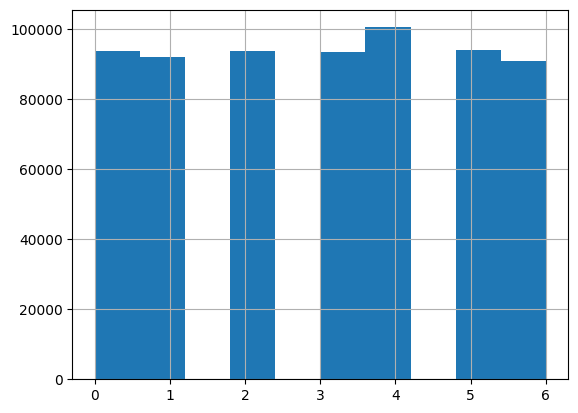

In [58]:
# dia da semana
dff_eda['day_of_week'].hist()

In [ ]:
# mês
dff_eda['month'].value_counts(normalize=True)

month
5     0.091623
1     0.091154
8     0.085720
10    0.085693
7     0.085192
3     0.083437
9     0.082280
11    0.079608
12    0.079489
4     0.079483
2     0.078496
6     0.077826
Name: proportion, dtype: float64

In [71]:
# hora do dia
dff_eda['hour'].value_counts(normalize=True)

hour
0     0.101235
12    0.055479
17    0.053692
18    0.053014
20    0.051946
16    0.048889
19    0.048584
22    0.048151
21    0.047651
15    0.046900
14    0.043049
13    0.041979
23    0.041541
11    0.037936
10    0.035988
8     0.034725
1     0.033999
9     0.033914
2     0.028159
7     0.025053
3     0.023769
4     0.022619
6     0.021423
5     0.020306
Name: proportion, dtype: float64

In [72]:
# identificação de outliers, possíveis erros em dados
dff_eda = dff_eda[(dff_eda['hour']!=0) & (dff_eda['minute']!=0)]

In [73]:
dff_eda['hour'].value_counts(normalize=True)

hour
16    0.057051
17    0.056234
15    0.055412
18    0.054106
20    0.053950
12    0.053522
14    0.053028
13    0.052656
19    0.052418
21    0.050509
11    0.047308
22    0.047102
23    0.044568
10    0.041535
9     0.038157
1     0.037719
8     0.036287
2     0.032586
7     0.030202
4     0.027885
3     0.027495
6     0.025280
5     0.024991
Name: proportion, dtype: float64

#### Tendências de aumento ou diminuição ao longo do tempo.

### Visualizações

#### Gráficos de linhas para evoluções temporais

#### Gráficos de barras para comparar tipos de crimes mais frequentes.

#### Mapas de calor (heatmaps) ou choropleth maps para visualizar concentração de crimes por região.

### Identificação de padrões e correlações

#### Correlacionar variáveis como hora do dia e tipo de crime.

#### verificar a influência de fatores externos (clima, eventos da cidade, período de férias escolares etc.).

### Formulação de hipóteses

#### “Crimes de furto de veículos aumentam em determinadas regiões durante a madrugada?”.

#### “Há correlação entre índices de desemprego ou renda e certos tipos de crimes?”.

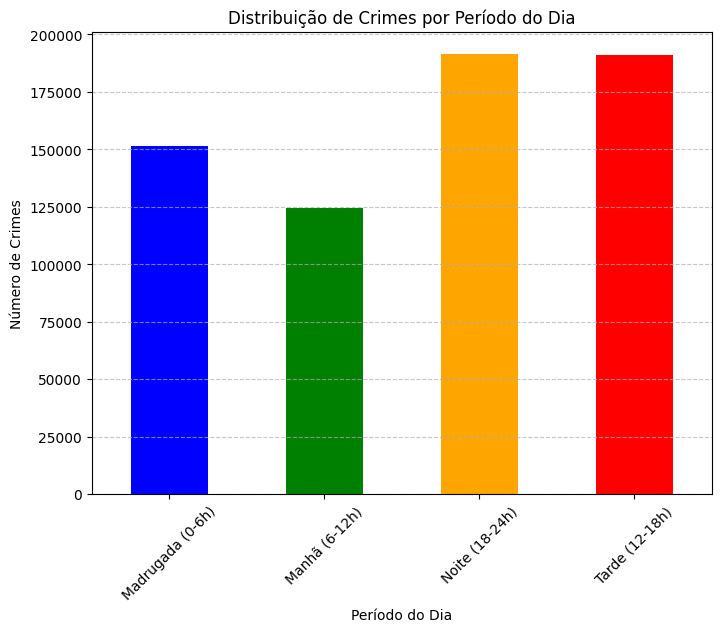

In [24]:
# Contagem de crimes por período
crime_por_periodo = dff_eda['periodo'].value_counts().sort_index()



# Criando gráfico para visualizar os períodos de maior risco
plt.figure(figsize=(8, 6))
crime_por_periodo.plot(kind='bar', color=['blue', 'green', 'orange', 'red'])
plt.xlabel("Período do Dia")
plt.ylabel("Número de Crimes")
plt.title("Distribuição de Crimes por Período do Dia")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


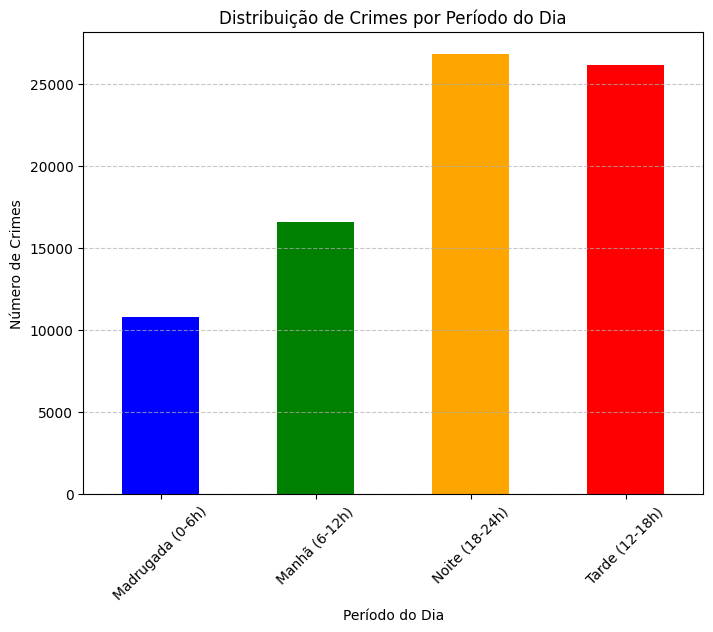

In [49]:
# Contagem de crimes por período
crime_por_periodo = test['periodo'].value_counts().sort_index()



# Criando gráfico para visualizar os períodos de maior risco
plt.figure(figsize=(8, 6))
crime_por_periodo.plot(kind='bar', color=['blue', 'green', 'orange', 'red'])
plt.xlabel("Período do Dia")
plt.ylabel("Número de Crimes")
plt.title("Distribuição de Crimes por Período do Dia")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
